<a href="https://colab.research.google.com/github/dtabuena/EphysLib/blob/main/Graph_a_Trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 'Get Standard Modules'

# import pandas as pd
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import scipy
# from scipy import stats
# import os
# from scipy.signal import butter,filtfilt
# from tqdm import tqdm
# import warnings
# from IPython.display import clear_output
# from datetime import datetime
# import sys
# import warnings
# import shutil
# from google.colab import files
# warnings.filterwarnings('ignore')
# np.set_printoptions(threshold=sys.maxsize)
# clear_output(wait=False)



# !pip install openpyxl
# !pip install XlsxWriter


# '''Get Repositories'''
# try: shutil.rmtree('/content/EphysLib')
# except: None

# "run dtabuena's ephys notebooks"
# !git clone https://github.com/dtabuena/EphysLib
# to_import = [
#             'ABF_Quality_Control.ipynb',
#             'Basic_Ephys.ipynb',
#             'Simple_ABF_tools.ipynb',
#             'fun_math.ipynb',
#             'importing_abfs_from_dropbox.ipynb',
#             'QC_recoding_dataframe.ipynb',
#             'Analyzers/input_resistance_analyzer.ipynb',
#             'Analyzers/gain_analyzer.ipynb',
#             'Analyzers/latencey_analyzer.ipynb',
#             'Analyzers/IV_analyzer.ipynb',
#             'Analyzers/Vm_analyzer.ipynb',
#             'Analyzers/membrane_analyzer.ipynb',
#             'Analyzers/rheobase_analyzer.ipynb',
#             'Ephys_wrapper.ipynb',
#             ]
# for i in to_import:
#     f = '/content/EphysLib/' + i
#     %run $f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 7.5 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1008, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 1008 (delta 294), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1008/1008), 14.34 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (671/671), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.3 MB/s eta 0:00:00


[0, 1, 2, 3]


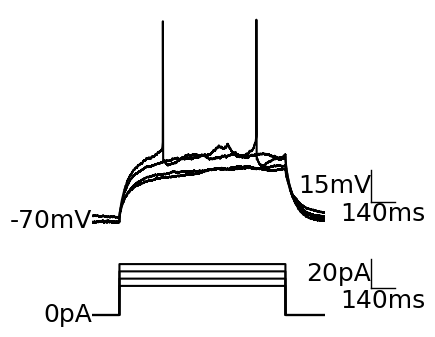

In [49]:
!wget 'https://www.dropbox.com/s/j0ts1hpt76xzvdq/arial.ttf'
mpl.font_manager.fontManager.addfont('/content/arial.ttf')

def sample_sweep_publish(abf,plot_ratio = (4,1) ,xlim=[],ylim=[],slim=np.inf,swp_list=[],use_ch2 = True,rel_xy_bar=[0.1, 0.1],base=[-70,0] ):
    plt.rcParams.update({'font.size': 18,'font.family': 'arial'})
    fig,ax = plt.subplots(2,figsize=(3,4),height_ratios=plot_ratio)

    swp_list = swp_list.tolist()
    print(swp_list)
    sweeps = abf.sweepList
    if len(swp_list)>0:
        sweeps = [s for s in sweeps if s in swp_list]
    sweeps = [s for s in sweeps if s<slim]

    for s in sweeps:   
        abf.setSweep(s,0)
        ax[0].plot(abf.sweepX*1000,abf.sweepY,'k')
        if use_ch2:
            abf.setSweep(s,1)
            ax[1].plot(abf.sweepX*1000,abf.sweepY,'k')
        else:
            abf.setSweep(s,0)
            ax[1].plot(abf.sweepX*1000,abf.sweepC,'k')
        # print(abf.adcUnits)
    if len(xlim) == 2:
        ax[0].set_xlim(xlim)
        ax[1].set_xlim(xlim)

    

    for i in range(len(ax)):
        axi = ax[i]
        axi.axis('off')
        xlim = axi.get_xlim()
        x_range = np.diff(xlim)
        x_bar_len = x_range*rel_xy_bar[0]
        x_bar_len = x_bar_len.astype("int")
        x_0 = xlim[1]+x_bar_len*2

        ylim = axi.get_ylim()
        y_range = np.diff(ylim)
        y_bar_len = y_range*rel_xy_bar[1]
        y_bar_len = y_bar_len*( np.sum(plot_ratio) / plot_ratio[i] )

        y_bar_len=5*np.ceil(y_bar_len/5).astype("int")

        y_0 = ylim[0]+y_bar_len

        lw = 1

        x,y = np.array([[x_0, x_0+x_bar_len], [y_0, y_0]])
        x_line = plt.Line2D(x, y, lw=lw, color='k', alpha=1)
        x_line.set_clip_on(False)

        axi.add_line(x_line)


        x,y = np.array([[x_0, x_0], [y_0, y_0+y_bar_len]])
        y_line = plt.Line2D(x, y, lw=lw, color='k', alpha=1)
        y_line.set_clip_on(False)

        axi.add_line(y_line)



        axi.text(x_0+x_bar_len/2, y_0,  str(x_bar_len[0])+'ms',ha='center',va='top')
        abf.adcUnits
        axi.text(x_0, y_0+y_bar_len/2,  str(y_bar_len[0])+abf.adcUnits[i],ha='right',va='center')

        
        axi.text(xlim[0],base[i],str(base[i]) + abf.adcUnits[i],ha='right',va='center')

    abf.setSweep(0,0)
    return None

sample_sweep_publish(abf,xlim=[400,1800],swp_list = np.arange(0,4),use_ch2=False,rel_xy_bar=[0.1, 0.1],base=[-70,0] )

